### 아이디어
- 추세가 일정할때 주기 t가 일정하다
- 왜냐면 통계. 그리고 중앙회귀는 모든 금융상품에 일어나는 일이여서
- 추세의 변환을 감정지수로 추론한다.(보안한다)


## I. 패키지 밎 자료 불러오기

In [1]:
!pip install pymysql
!pip install sqlalchemy

     |████████████████████████████████| 43 kB 1.1 MB/s 


In [2]:
import warnings
warnings.filterwarnings('ignore')
import time
import datetime
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import operator

import base64
from io import BytesIO

from datetime import datetime, timedelta


from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### 1) 나중에 데이터베이스 커리해서 가져오기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls -l '/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_market/Bitcoin.csv'

-rw------- 1 root root 113203 Nov 21 05:53 '/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_market/Bitcoin.csv'


In [5]:
BTC = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_market/Bitcoin.csv')

In [6]:
BTC

,Date,Price,Open,High,Low,Vol.,Change %
0,"Nov 21, 2021","58,917.3","59,724.0","59,771.9","58,582.8",42.65K,-1.34%
1,"Nov 20, 2021","59,717.6","58,080.8","59,854.6","57,435.3",44.53K,2.81%
2,"Nov 19, 2021","58,083.4","56,908.3","58,335.9","55,626.3",74.44K,1.98%
3,"Nov 18, 2021","56,955.3","60,368.2","60,936.9","56,524.4",100.37K,-5.65%
4,"Nov 17, 2021","60,367.8","60,074.2","60,814.5","58,531.9",73.93K,0.46%
...,...,...,...,...,...,...,...
1488,"Oct 25, 2017","5,734.0","5,513.1","5,748.0","5,375.6",105.84K,4.01%
1489,"Oct 24, 2017","5,513.1","5,903.6","5,904.6","5,463.4",143.74K,-6.62%
1490,"Oct 23, 2017","5,903.6","5,982.9","6,049.0","5,644.2",137.14K,-1.32%
1491,"Oct 22, 2017","5,982.9","6,006.6","6,070.6","5,723.0",105.03K,-0.40%


### 2) 변수 정의 밎 전처리

In [7]:
n = [7,14,30,60,180]
crypto = [BTC]
crypto_name = ['BTC']
bounds = [30,60,180,360,720]

In [8]:
B = []
for j,k in zip(crypto,crypto_name) :
  for i in range(len(j)):
    x = j['Price'][i]
    date_time_obj = datetime.strptime(j['Date'][i], '%b %d, %Y')
    a = date_time_obj.strftime("%Y-%m-%d")
    b = j['Vol.'][i]
    Y = [a,b,x]
    B.append(Y)
  globals()[k] = pd.DataFrame(B)
  globals()[k].columns = ['date','volume','price']
  # globals()[k] = globals()[k].set_index('date')
  print('완료')

완료


In [9]:
DF_price = BTC

In [10]:
for i in range(len(DF_price['price'])):
  DF_price['price'][i] = DF_price['price'][i].replace(',','')
for i in range(len(DF_price['volume'])):
  DF_price['volume'][i] = DF_price['volume'][i].replace('K','')  
  DF_price['volume'][i] = DF_price['volume'][i].replace('M','') 

In [11]:
DF_price

,date,volume,price
0,2021-11-21,42.65,58917.3
1,2021-11-20,44.53,59717.6
2,2021-11-19,74.44,58083.4
3,2021-11-18,100.37,56955.3
4,2021-11-17,73.93,60367.8
...,...,...,...
1488,2017-10-25,105.84,5734.0
1489,2017-10-24,143.74,5513.1
1490,2017-10-23,137.14,5903.6
1491,2017-10-22,105.03,5982.9


In [12]:
for i in range(len(DF_price['price'])):
  DF_price['price'][i] = pd.to_numeric(DF_price['price'][i], downcast = 'float')
  DF_price['volume'][i] = pd.to_numeric(DF_price['volume'][i], downcast = 'float')

In [13]:
DF_price

,date,volume,price
0,2021-11-21,42.65,58917.3
1,2021-11-20,44.53,59717.6
2,2021-11-19,74.44,58083.4
3,2021-11-18,100.37,56955.3
4,2021-11-17,73.93,60367.8
...,...,...,...
1488,2017-10-25,105.84,5734
1489,2017-10-24,143.74,5513.1
1490,2017-10-23,137.14,5903.6
1491,2017-10-22,105.03,5982.9


In [14]:
DF = DF_price

## II. 이동평균선 작업

In [15]:
  for i in n:
    DF_price['MA{0};'.format(i)]= DF_price['price'].rolling(window=i).mean().shift(-(i-1))
    print('완료', 'MA{0};'.format(i))

완료 MA7;
완료 MA14;
완료 MA30;
완료 MA60;
완료 MA180;


In [16]:
DF = DF_price

## III.표준편차,Z밸류,이격도 작업

In [17]:
for i in n :
  DF_price['MA{0};SD;'.format(i)]=DF_price['price'].rolling(window=i).std().shift(-(i-1))
for i in n :
  DF_price['MA{0};z_value;'.format(i)] = (DF_price['price']-DF_price['MA{0};'.format(i)])/(DF_price['MA{0};SD;'.format(i)])

In [18]:
DF = DF_price

In [19]:
DF_price

,date,volume,price,MA7;,MA14;,MA30;,MA60;,MA180;,MA7;SD;,MA14;SD;,MA30;SD;,MA60;SD;,MA180;SD;,MA7;z_value;,MA14;z_value;,MA30;z_value;,MA60;z_value;,MA180;z_value;
0,2021-11-21,42.65,58917.3,59675.486049,62567.235770,62003.690234,57451.686849,45897.920106,2103.428388,3437.024326,2531.724005,7342.575827,10520.197008,-0.360452,-1.06195,-1.21909,0.199605,1.23756
1,2021-11-20,44.53,59717.6,60617.042969,62878.371373,62062.790234,57195.591862,45783.814551,2994.062399,3274.515287,2477.300911,7555.468370,10489.537314,-0.300408,-0.965263,-0.946671,0.333799,1.32835
2,2021-11-19,74.44,58083.4,61285.757254,63004.535435,62145.876823,56877.820182,45667.331217,3269.745068,3175.908114,2437.411660,7843.074608,10450.284997,-0.979391,-1.54952,-1.66672,0.153712,1.18811
3,2021-11-18,100.37,56955.3,62150.200335,63211.028460,62409.066927,56624.273568,45537.310666,3076.166370,2914.557794,2409.751044,8046.693120,10440.531271,-1.68876,-2.14637,-2.26321,0.0411383,1.09362
4,2021-11-17,73.93,60367.8,63271.828683,63529.407087,62653.173568,56462.330208,45428.938444,2161.806772,2371.489535,2200.028809,8137.184817,10422.576391,-1.34333,-1.33317,-1.03879,0.479954,1.43332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,2017-10-25,105.84,5734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1489,2017-10-24,143.74,5513.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1490,2017-10-23,137.14,5903.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1491,2017-10-22,105.03,5982.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
DF_price['disparity7;']= DF_price['price']/DF_price['MA7;']
DF_price['disparity14;']= DF_price['price']/DF_price['MA14;']
DF_price['disparity30;']= DF_price['price']/DF_price['MA30;']
DF_price['disparity60;']= DF_price['price']/DF_price['MA60;']
DF_price['disparity180;']= DF_price['price']/DF_price['MA180;']

## IV. 테스트 셋 만들기

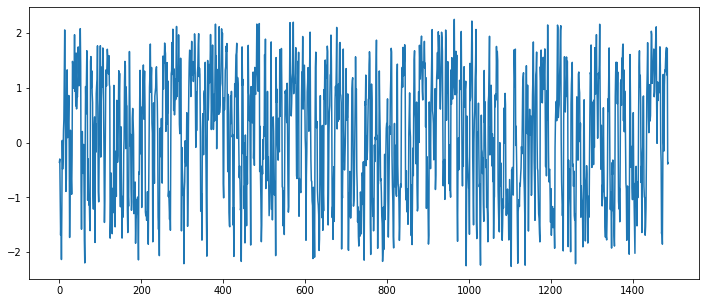

In [21]:
MA7_z_value_data = DF_price[['MA7;z_value;']]

plt.figure(figsize = (12, 5))
plt.plot(MA7_z_value_data)
plt.show()

In [22]:
print(DF_price[['date','MA7;z_value;']].head())
print(DF_price[['date','MA7;z_value;']].tail())

         date MA7;z_value;
0  2021-11-21    -0.360452
1  2021-11-20    -0.300408
2  2021-11-19    -0.979391
3  2021-11-18     -1.68876
4  2021-11-17     -1.34333
            date MA7;z_value;
1488  2017-10-25          NaN
1489  2017-10-24          NaN
1490  2017-10-23          NaN
1491  2017-10-22          NaN
1492  2017-10-21          NaN


In [23]:
test = DF_price['MA7;z_value;'].dropna()

- projects 데이터는 0열이 가장오래된날짜(정렬역순)

In [24]:
test = test[::-1].reset_index()

In [25]:
print(test.head())
print(test.tail())

   index MA7;z_value;
0   1486    -0.365954
1   1485    -0.392918
2   1484      1.71265
3   1483      1.23122
4   1482      1.73227
      index MA7;z_value;
1482      4     -1.34333
1483      3     -1.68876
1484      2    -0.979391
1485      1    -0.300408
1486      0    -0.360452


In [26]:
test =  test[['MA7;z_value;']]

In [27]:
test

,MA7;z_value;
0,-0.365954
1,-0.392918
2,1.71265
3,1.23122
4,1.73227
...,...
1482,-1.34333
1483,-1.68876
1484,-0.979391
1485,-0.300408


In [28]:
scaler = MinMaxScaler(feature_range = (-1, 1))

MA7_z_value_data = scaler.fit_transform(test)

In [29]:
MA7_z_value_data

array([[-0.15932719],
       [-0.17129891],
       [ 0.76352405],
       ...,
       [-0.43167906],
       [-0.13022668],
       [-0.15688471]])

In [30]:
# 트레인(과거 -1년) , 테스트(-1년 ~ 현재)   1486-365 =1121
train = MA7_z_value_data[0:1121]
test = MA7_z_value_data[1121:]

In [31]:
test

array([[ 4.85025510e-01],
       [ 2.89312456e-01],
       [ 1.84544730e-01],
       [ 6.66989278e-01],
       [ 1.90739603e-01],
       [-9.16814557e-01],
       [-6.21835055e-01],
       [-2.06519717e-01],
       [ 7.23812803e-02],
       [ 6.52188593e-01],
       [ 2.73124298e-01],
       [ 4.23430169e-01],
       [ 3.95192536e-01],
       [-9.57523195e-02],
       [ 1.16336748e-01],
       [ 2.36172532e-01],
       [ 9.35273052e-02],
       [-7.87015316e-01],
       [-4.09465773e-01],
       [-5.26627216e-01],
       [-5.52572893e-01],
       [ 1.50275247e-01],
       [ 5.53652991e-01],
       [ 6.04719544e-01],
       [ 5.36828177e-01],
       [ 8.84073379e-01],
       [ 8.02157220e-01],
       [ 6.20934993e-01],
       [ 5.67201899e-01],
       [ 3.68060580e-01],
       [ 9.93084540e-02],
       [ 4.14707459e-01],
       [-3.63392231e-02],
       [ 3.33413689e-01],
       [ 7.66737576e-01],
       [ 8.82404676e-01],
       [ 5.65951446e-01],
       [ 5.88716413e-01],
       [ 4.9

### 1) 학습생성 데이터 생성 함수 정의

In [ ]:
# # time_priod 몃일간 데이터를 줄것인가?
# def create_dataset(time_data, time_priod , prediction):
#   data_X, data_y = [], []

#   for i in range(len(time_date) - time_priod):
#     date_X.append(time_data[i+1:(i+1 + time_priod), 0])
#     date_y.append(time_data[i+1 - prediction, 0])

#   return np.array(data_X), np.array(data_y)

- look_back AI가 참조해할 날의 수

In [32]:
def create_dataset(time_data, look_back = 1):
    data_X, data_y = [], []

    for i in range(len(time_data) - look_back):
        data_X.append(time_data[i:(i + look_back), 0])
        data_y.append(time_data[i + look_back, 0])

    return np.array(data_X), np.array(data_y)

In [ ]:
look_back = 28

train_X, train_y = create_dataset(train, look_back)
test_X,  test_y  = create_dataset(test, look_back)

### 2) 셋 눈으로 확인해보기

In [ ]:
test_X

array([[ 0.48502551,  0.28931246,  0.18454473, ...,  0.88407338,
         0.80215722,  0.62093499],
       [ 0.28931246,  0.18454473,  0.66698928, ...,  0.80215722,
         0.62093499,  0.5672019 ],
       [ 0.18454473,  0.66698928,  0.1907396 , ...,  0.62093499,
         0.5672019 ,  0.36806058],
       ...,
       [-0.41556785, -0.29649782, -0.36461713, ..., -0.94398628,
        -0.59326111, -0.74662127],
       [-0.29649782, -0.36461713,  0.10263014, ..., -0.59326111,
        -0.74662127, -0.43167906],
       [-0.36461713,  0.10263014, -0.39134565, ..., -0.74662127,
        -0.43167906, -0.13022668]])

In [ ]:
test_y

array([ 5.67201899e-01,  3.68060580e-01,  9.93084540e-02,  4.14707459e-01,
       -3.63392231e-02,  3.33413689e-01,  7.66737576e-01,  8.82404676e-01,
        5.65951446e-01,  5.88716413e-01,  4.96942358e-01,  6.58068653e-01,
        5.51204883e-01,  5.58719233e-01,  8.21820923e-01,  6.77893298e-01,
        3.75406121e-01,  5.95279231e-01,  7.40565665e-01,  7.50691029e-01,
        6.51757779e-01,  4.44894851e-01,  1.22715779e-01, -4.04180093e-01,
       -6.75184684e-01, -9.43875566e-02,  2.44042721e-01, -1.01641038e-01,
       -1.86176988e-01, -1.55146146e-01,  1.69917204e-02, -3.15176663e-01,
       -3.87656024e-01, -9.77756130e-01, -3.81724592e-01, -4.25383418e-01,
       -2.95318023e-01, -2.01784371e-01, -3.66506266e-02, -7.11954510e-01,
        5.25626452e-01,  6.85649799e-01,  4.95848373e-01,  7.49914454e-02,
        1.51261938e-01,  5.62577701e-01,  8.74488150e-01,  5.00246677e-01,
        5.78473812e-01,  5.52616150e-01,  3.74614895e-01,  9.42589654e-01,
        6.48267611e-01,  

In [ ]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((1093, 28, 1), (1093,), (338, 28, 1), (338,))

## V.LSTM 모델

In [ ]:
model = Sequential(name = 'LSTM')
model.add(LSTM(128, 
               input_shape = (None, 1)))
model.add(Dense(1, activation = 'tanh'))

In [ ]:
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = 'mean_squared_error', 
              optimizer = 'adam')

In [ ]:
%%time

hist = model.fit(train_X, train_y,
                 epochs = 200, 
                 batch_size = 16,  
                 validation_data = (test_X, test_y))

Epoch 1/200
69/69 [==============================] - 7s 19ms/step - loss: 0.1986 - val_loss: 0.1577
Epoch 2/200
69/69 [==============================] - 1s 11ms/step - loss: 0.1517 - val_loss: 0.1356
Epoch 3/200
69/69 [==============================] - 1s 11ms/step - loss: 0.1370 - val_loss: 0.1286
Epoch 4/200
69/69 [==============================] - 1s 11ms/step - loss: 0.1335 - val_loss: 0.1264
Epoch 5/200
69/69 [==============================] - 1s 11ms/step - loss: 0.1311 - val_loss: 0.1270
Epoch 6/200
69/69 [==============================] - 1s 12ms/step - loss: 0.1311 - val_loss: 0.1257
Epoch 7/200
69/69 [==============================] - 1s 12ms/step - loss: 0.1313 - val_loss: 0.1263
Epoch 8/200
69/69 [==============================] - 1s 11ms/step - loss: 0.1307 - val_loss: 0.1266
Epoch 9/200
69/69 [==============================] - 1s 11ms/step - loss: 0.1312 - val_loss: 0.1257
Epoch 10/200
69/69 [==============================] - 1s 12ms/step - loss: 0.1305 - val_loss: 0.1260

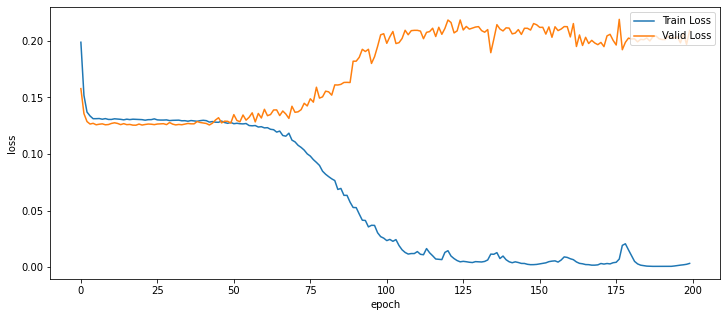

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

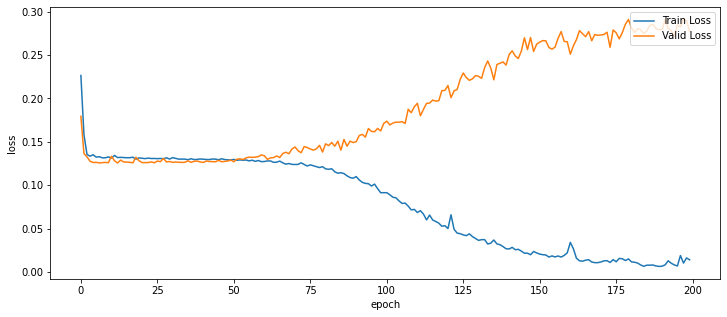

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

In [ ]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  0.0033583969343453646
Test Score:  0.20895421504974365


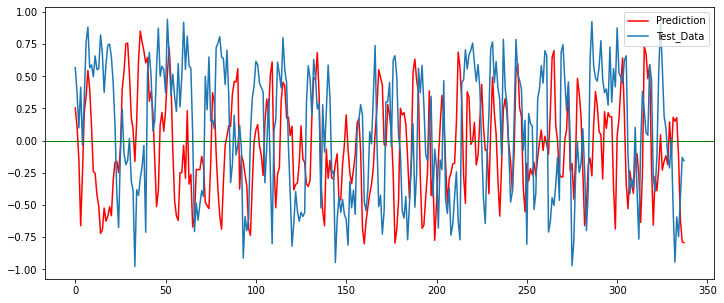

In [ ]:
look_ahead = 338
# look_ahead = 30

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
   
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.axhline(y=0, color='g', linewidth=1)
plt.legend()
plt.show()

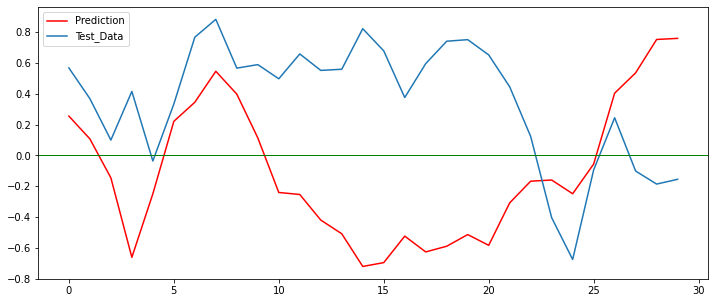

In [ ]:
# look_ahead = 338
look_ahead = 30

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
  
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.axhline(y=0, color='g', linewidth=1)  
plt.legend()
plt.show()

## ---- 변화주기 (학습에 필요한 일수는?)

In [ ]:
look_back = 7

train_X, train_y = create_dataset(train, look_back)
test_X,  test_y  = create_dataset(test, look_back)

In [ ]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((1114, 7, 1), (1114,), (359, 7, 1), (359,))

In [ ]:
model = Sequential(name = 'LSTM')
model.add(LSTM(128, 
               input_shape = (None, 1)))
model.add(Dense(1, activation = 'tanh'))

In [ ]:
model.compile(loss = 'mean_squared_error', 
              optimizer = 'adam')

In [ ]:
%%time

hist = model.fit(train_X, train_y,
                 epochs = 200, 
                 batch_size = 16,  
                 validation_data = (test_X, test_y))

Epoch 1/200
70/70 [==============================] - 3s 14ms/step - loss: 0.1908 - val_loss: 0.1494
Epoch 2/200
70/70 [==============================] - 1s 7ms/step - loss: 0.1481 - val_loss: 0.1341
Epoch 3/200
70/70 [==============================] - 0s 6ms/step - loss: 0.1349 - val_loss: 0.1254
Epoch 4/200
70/70 [==============================] - 1s 8ms/step - loss: 0.1312 - val_loss: 0.1256
Epoch 5/200
70/70 [==============================] - 0s 6ms/step - loss: 0.1319 - val_loss: 0.1246
Epoch 6/200
70/70 [==============================] - 1s 7ms/step - loss: 0.1309 - val_loss: 0.1280
Epoch 7/200
70/70 [==============================] - 0s 6ms/step - loss: 0.1310 - val_loss: 0.1255
Epoch 8/200
70/70 [==============================] - 0s 6ms/step - loss: 0.1305 - val_loss: 0.1252
Epoch 9/200
70/70 [==============================] - 0s 6ms/step - loss: 0.1303 - val_loss: 0.1249
Epoch 10/200
70/70 [==============================] - 0s 7ms/step - loss: 0.1308 - val_loss: 0.1257
Epoch 11

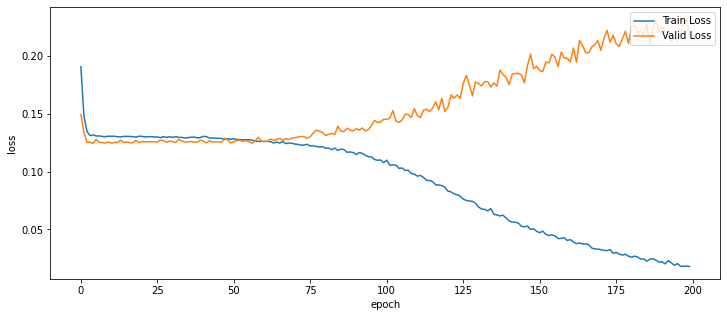

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

In [ ]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  0.013340405188500881
Test Score:  0.21812373399734497


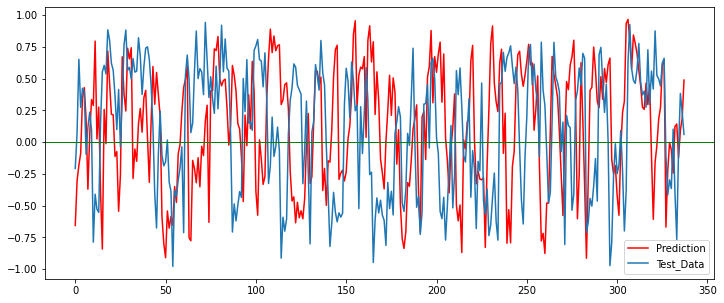

In [ ]:
look_ahead = 338
# look_ahead = 30

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
   
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.axhline(y=0, color='g', linewidth=1)
plt.legend()
plt.show()

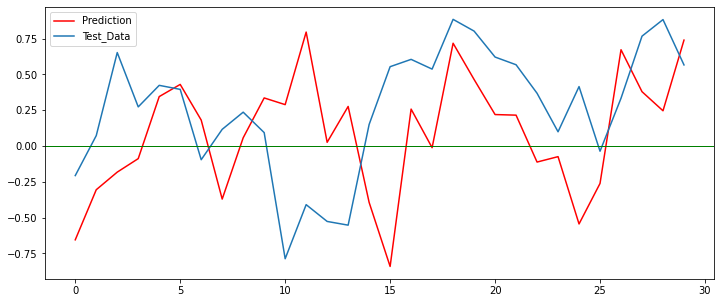

In [ ]:
# look_ahead = 338
look_ahead = 30

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
   
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.axhline(y=0, color='g', linewidth=1)
plt.legend()
plt.show()

## ----변화주기 (학습 횟수 변화)

In [61]:
look_back = 3

train_X, train_y = create_dataset(train, look_back)
test_X,  test_y  = create_dataset(test, look_back)

In [62]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((1118, 3, 1), (1118,), (363, 3, 1), (363,))

In [63]:
model = Sequential(name = 'LSTM')
model.add(LSTM(64, 
               input_shape = (None, 1)))
model.add(Dense(1, activation = 'tanh'))

In [64]:
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.compile(loss = 'mean_squared_error', 
              optimizer = 'adam')

In [66]:
%%time

hist = model.fit(train_X, train_y,
                 epochs = 2048,
                 batch_size = 16,  
                 validation_data = (test_X, test_y))

Epoch 1/2048
70/70 [==============================] - 3s 14ms/step - loss: 0.2056 - val_loss: 0.1745
Epoch 2/2048
70/70 [==============================] - 0s 6ms/step - loss: 0.1719 - val_loss: 0.1529
Epoch 3/2048
70/70 [==============================] - 0s 6ms/step - loss: 0.1503 - val_loss: 0.1388
Epoch 4/2048
70/70 [==============================] - 0s 6ms/step - loss: 0.1364 - val_loss: 0.1305
Epoch 5/2048
70/70 [==============================] - 0s 6ms/step - loss: 0.1318 - val_loss: 0.1296
Epoch 6/2048
70/70 [==============================] - 0s 6ms/step - loss: 0.1305 - val_loss: 0.1282
Epoch 7/2048
70/70 [==============================] - 0s 6ms/step - loss: 0.1310 - val_loss: 0.1278
Epoch 8/2048
70/70 [==============================] - 0s 6ms/step - loss: 0.1306 - val_loss: 0.1275
Epoch 9/2048
70/70 [==============================] - 0s 7ms/step - loss: 0.1300 - val_loss: 0.1280
Epoch 10/2048
70/70 [==============================] - 0s 6ms/step - loss: 0.1308 - val_loss: 0.128

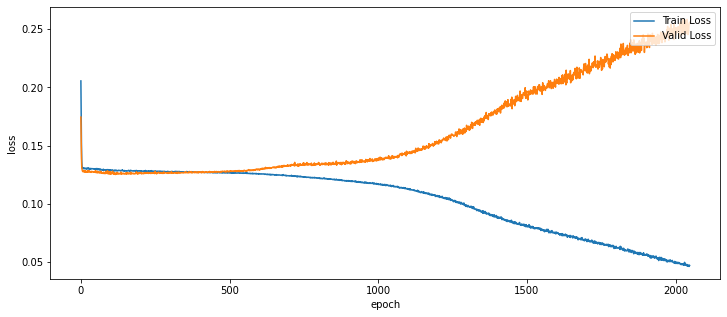

In [67]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

In [68]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  0.043180130422115326
Test Score:  0.2559938132762909


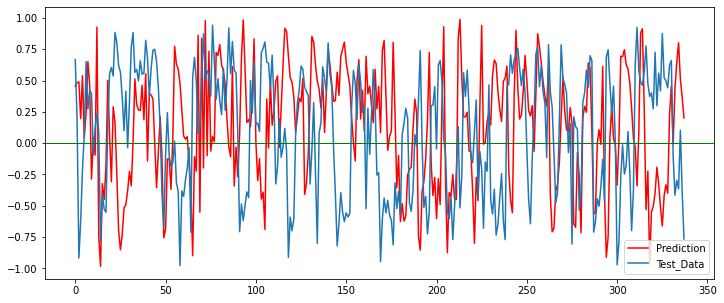

In [69]:
look_ahead = 338
# look_ahead = 30

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
   
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.axhline(y=0, color='g', linewidth=1)
plt.legend()
plt.show()

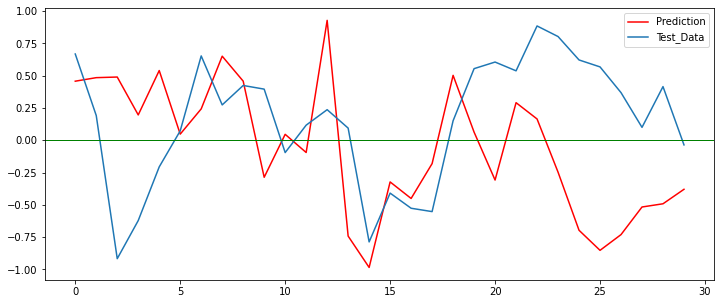

In [70]:
# look_ahead = 338
look_ahead = 30

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
   
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.axhline(y=0, color='g', linewidth=1)
plt.legend()
plt.show()

## IV. EDA z_value

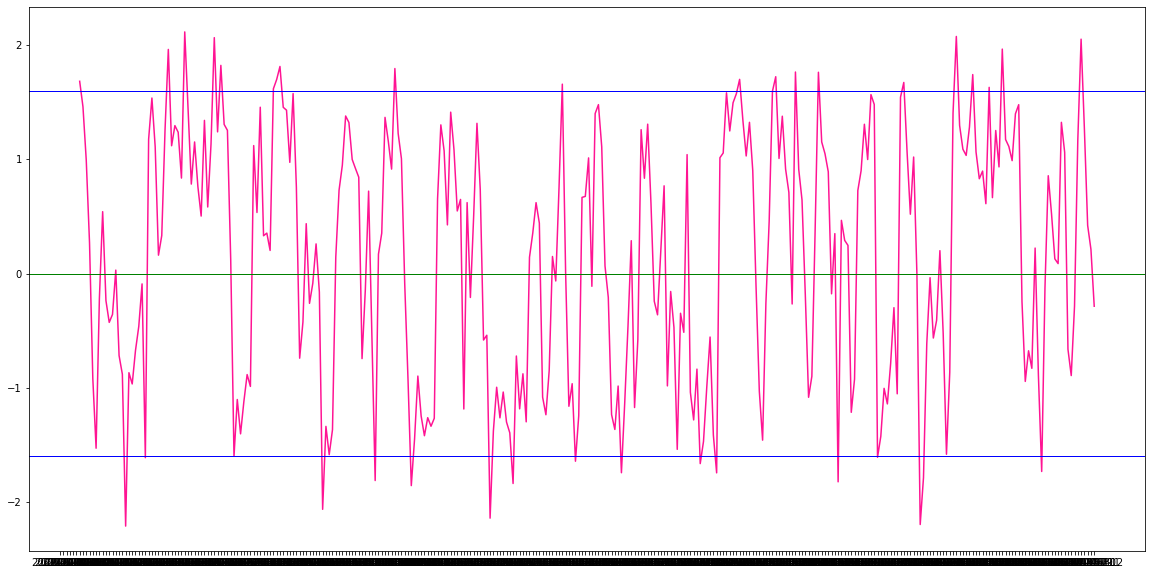

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA7;z_value;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)
plt.axhline(y=1.6, color='b', linewidth=1)
plt.axhline(y=-1.6, color='b', linewidth=1)

plt.show()


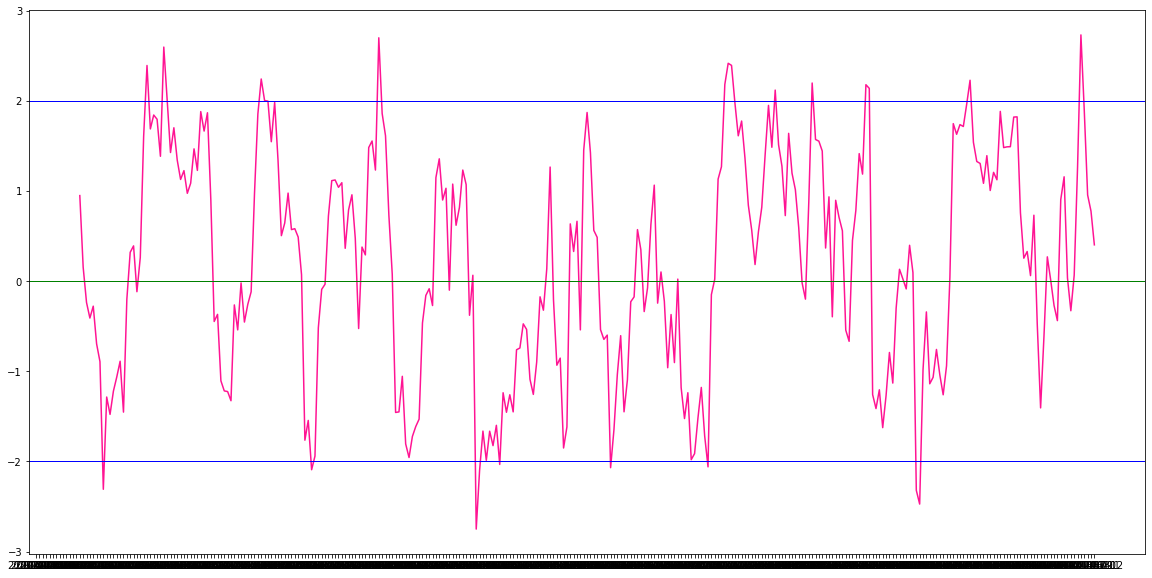

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA14;z_value;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)
plt.axhline(y=2, color='b', linewidth=1)
plt.axhline(y=-2, color='b', linewidth=1)

plt.show()



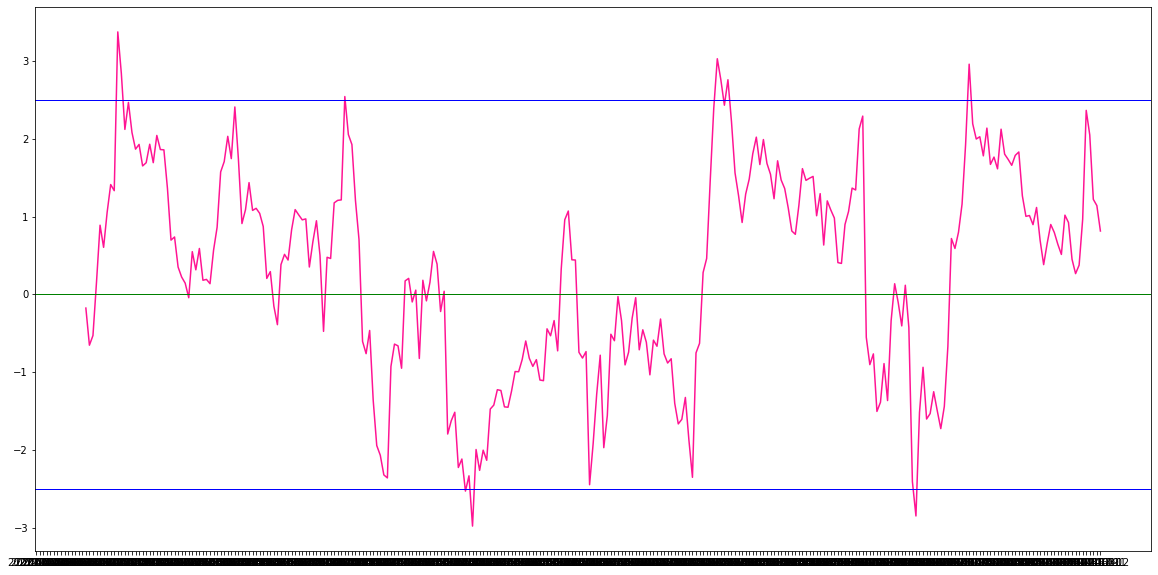

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA30;z_value;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')
plt.axhline(y=2.5, color='b', linewidth=1)
plt.axhline(y=-2.5, color='b', linewidth=1)

plt.axhline(y=0, color='g', linewidth=1)

plt.show()


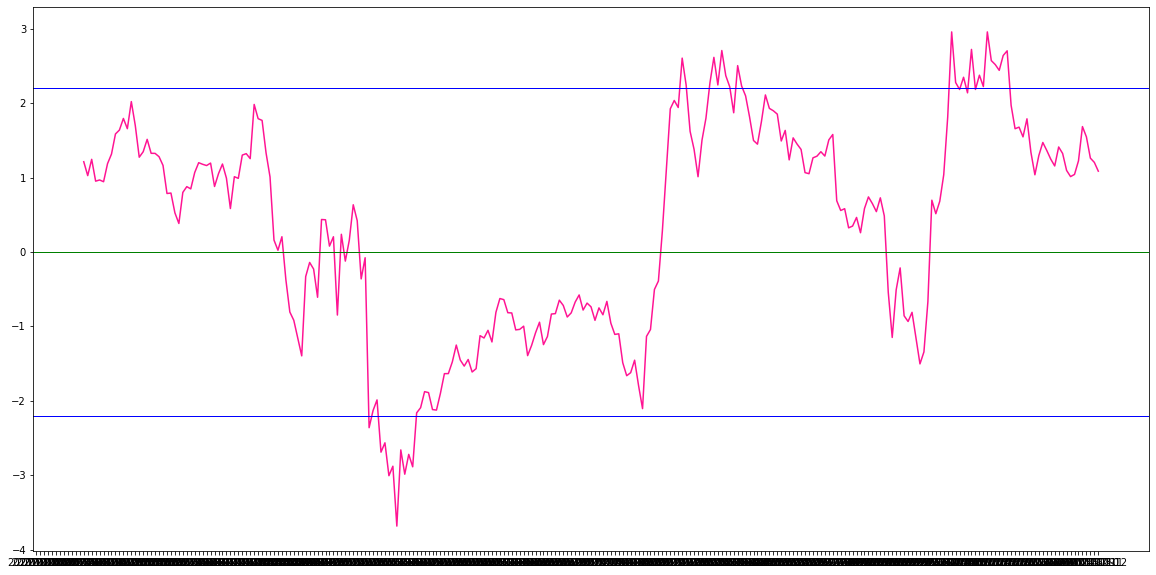

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA60;z_value;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)
plt.axhline(y=2.2, color='b', linewidth=1)
plt.axhline(y=-2.2, color='b', linewidth=1)

plt.show()

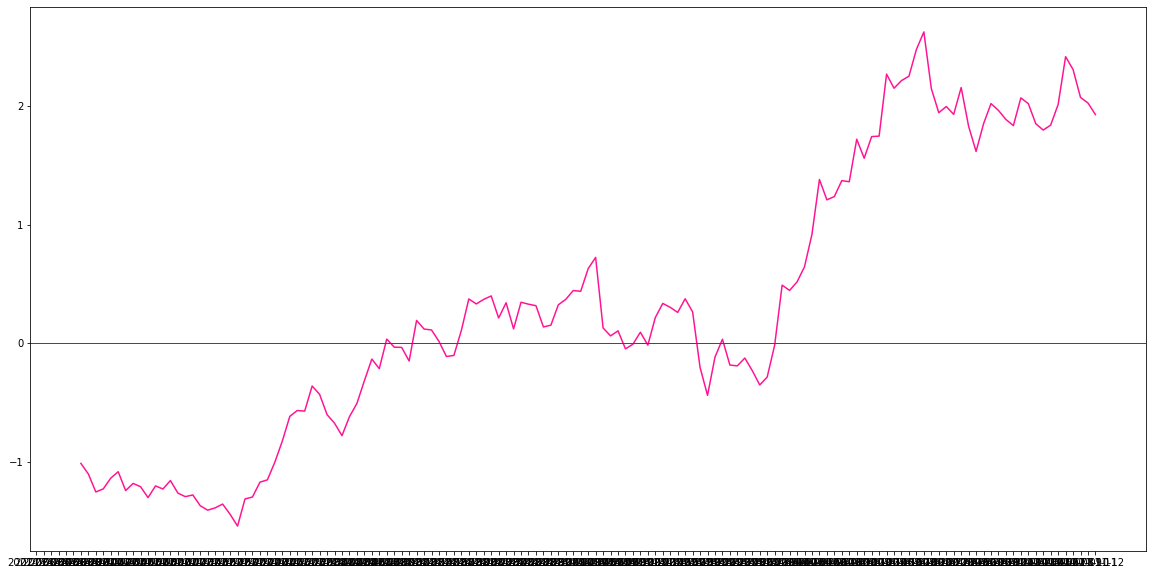

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA180;z_value;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

## V. z_value 평균이동선 작업밎 EDA

In [ ]:
  for i in n:
    DF_price['MA{0};z_value;MA{0};'.format(i)]= DF_price['MA{0};z_value;'.format(i)].rolling(window=i).mean().shift(-(i-1))
    print('완료', 'MA{0};''MA{0};z_value;MA{0};'.format(i))

완료 MA7;MA7;z_value;MA7;
완료 MA14;MA14;z_value;MA14;
완료 MA30;MA30;z_value;MA30;
완료 MA60;MA60;z_value;MA60;
완료 MA180;MA180;z_value;MA180;


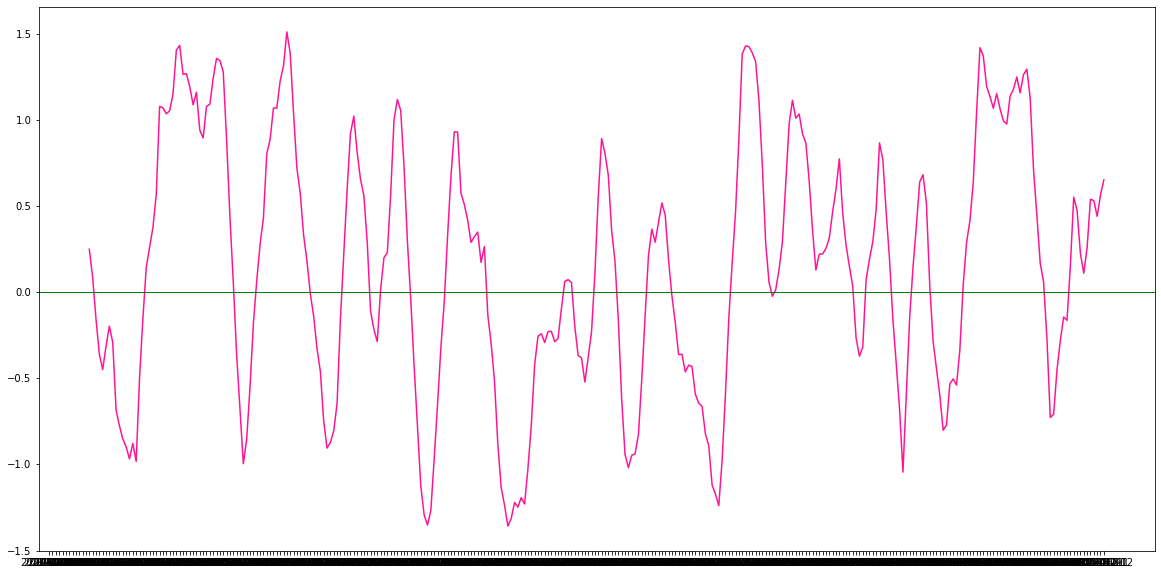

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA7;z_value;MA7;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()


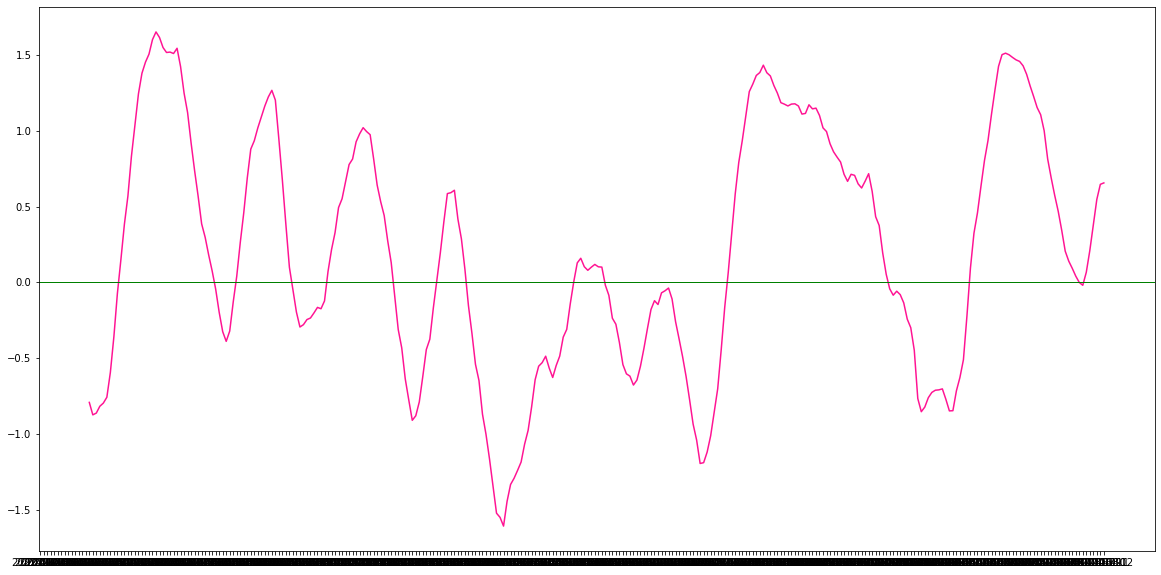

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA14;z_value;MA14;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

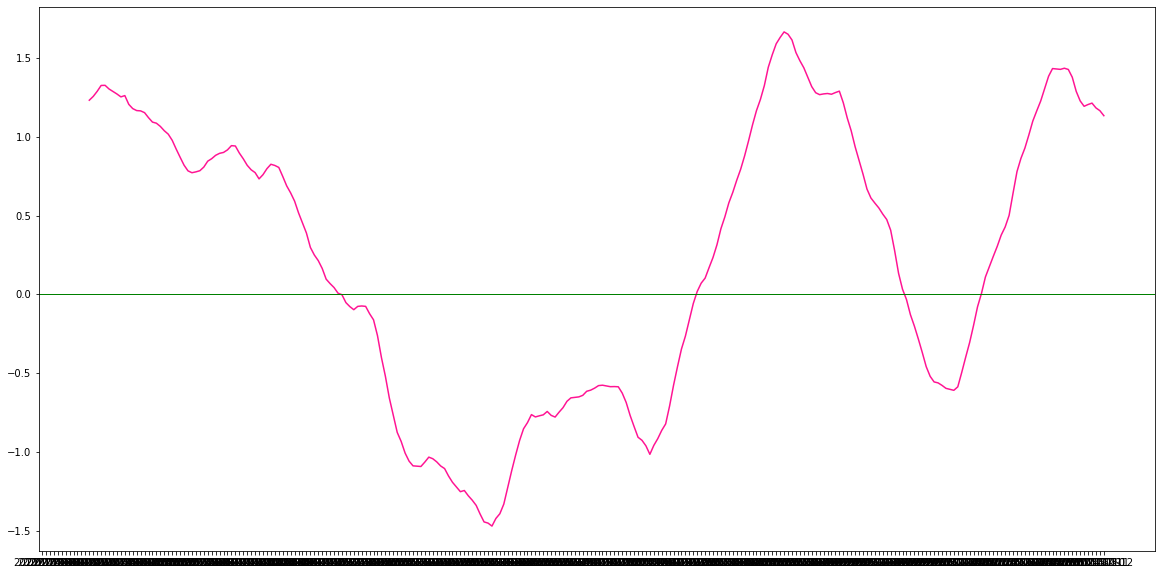

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA30;z_value;MA30;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

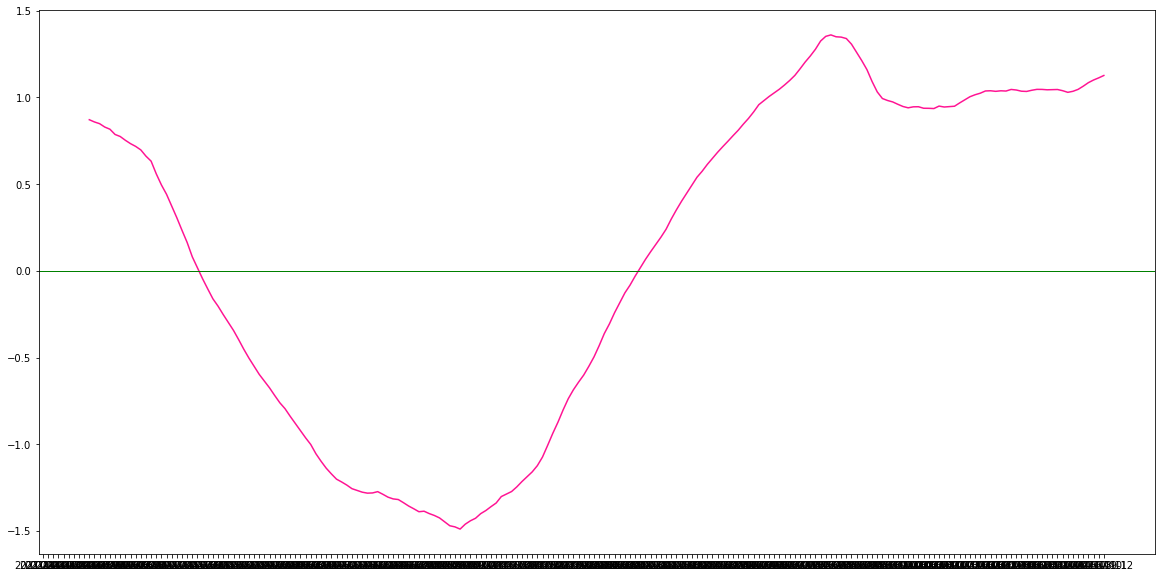

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA60;z_value;MA60;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

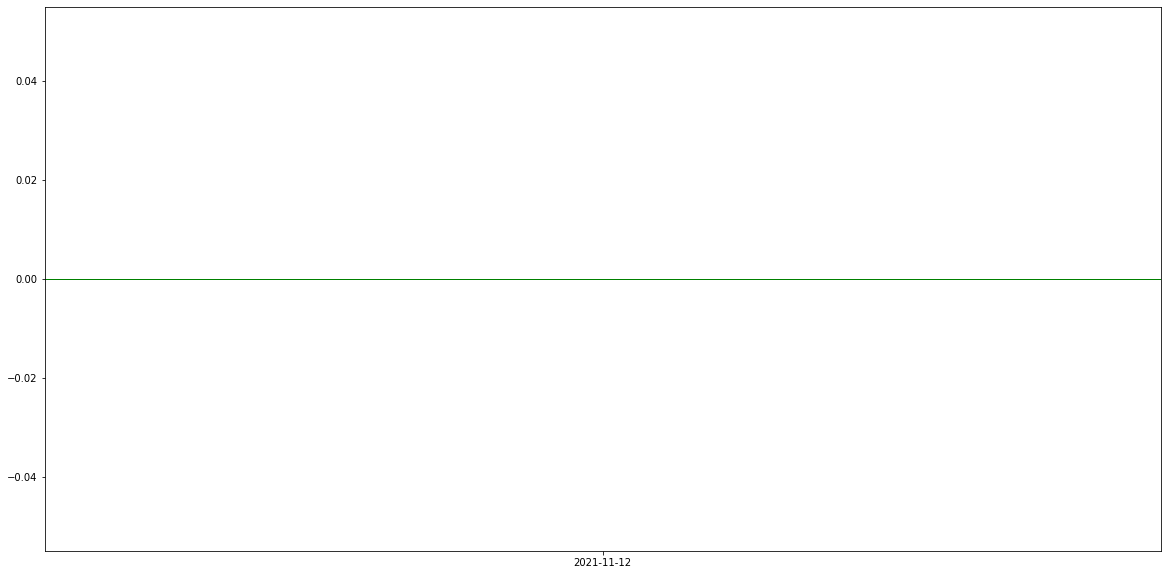

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA180;z_value;MA180;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

## VI. 이격도(disparity) 작업 밎 EDA

In [ ]:
DF_price['disparity7;']= DF_price['price']/DF_price['MA7;']
DF_price['disparity14;']= DF_price['price']/DF_price['MA14;']
DF_price['disparity30;']= DF_price['price']/DF_price['MA30;']
DF_price['disparity60;']= DF_price['price']/DF_price['MA60;']
DF_price['disparity180;']= DF_price['price']/DF_price['MA180;']

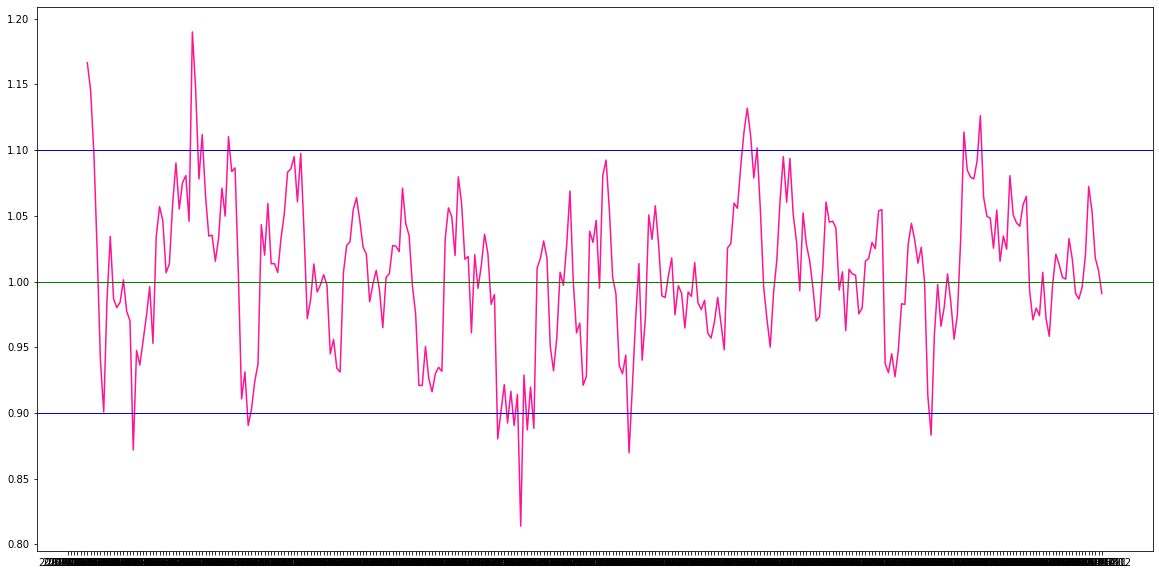

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['disparity7;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=1, color='g', linewidth=1)
plt.axhline(y=1.1, color='b', linewidth=1)
plt.axhline(y=0.90, color='b', linewidth=1)

plt.show()


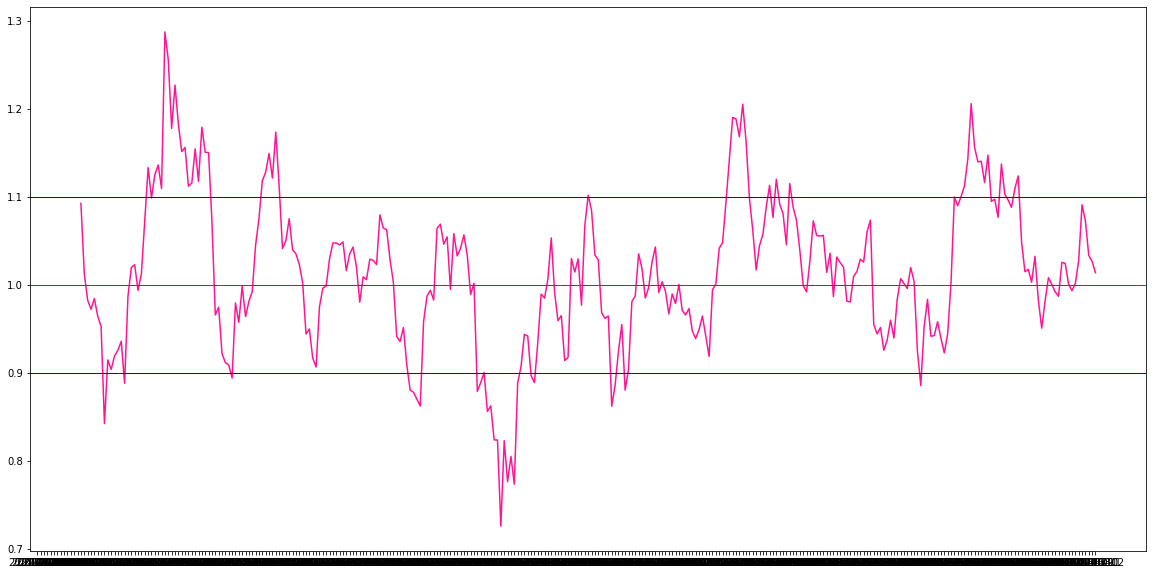

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['disparity14;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')
plt.axhline(y=1.1, color='b', linewidth=1)
plt.axhline(y=0.90, color='b', linewidth=1)

plt.axhline(y=1, color='g', linewidth=1)

plt.show()


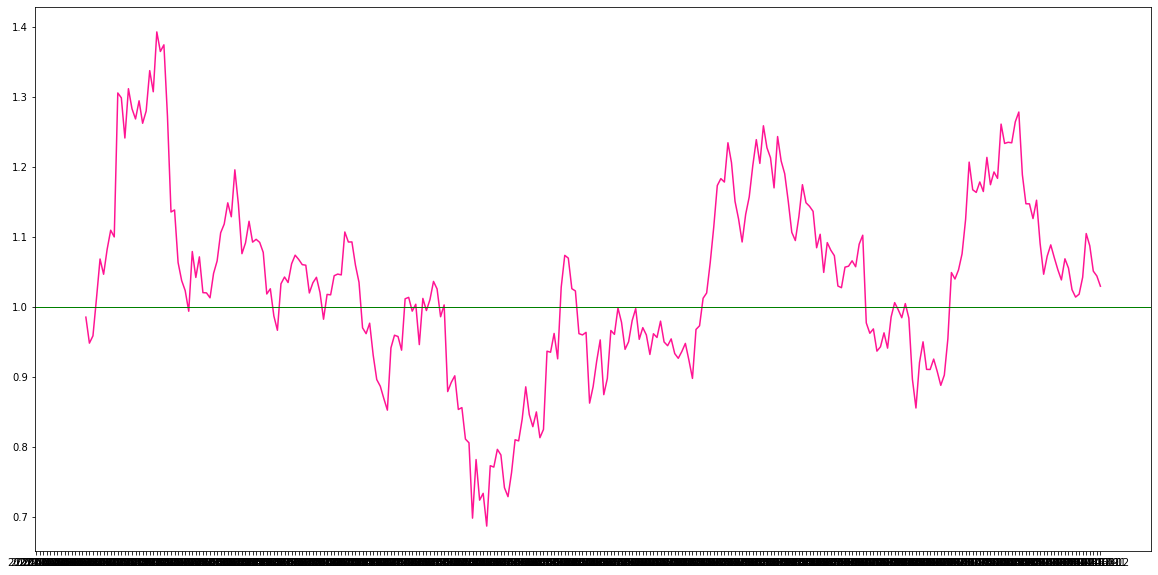

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['disparity30;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')
# plt.axhline(y=1.25, color='b', linewidth=1)
# plt.axhline(y=0.75, color='b', linewidth=1)

plt.axhline(y=1, color='g', linewidth=1)

plt.show()


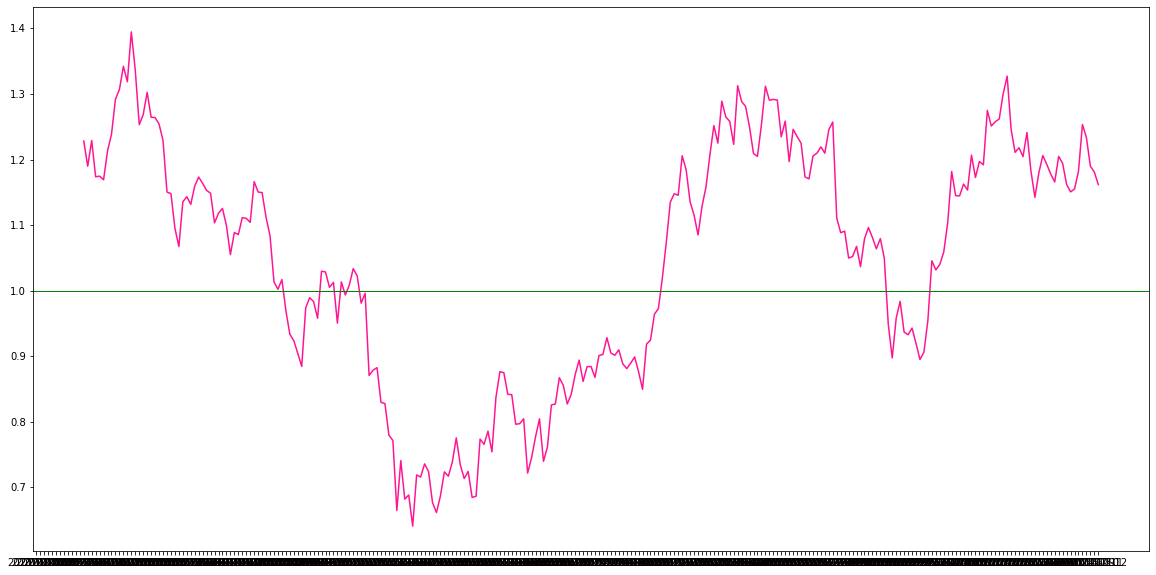

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['disparity60;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=1, color='g', linewidth=1)

plt.show()


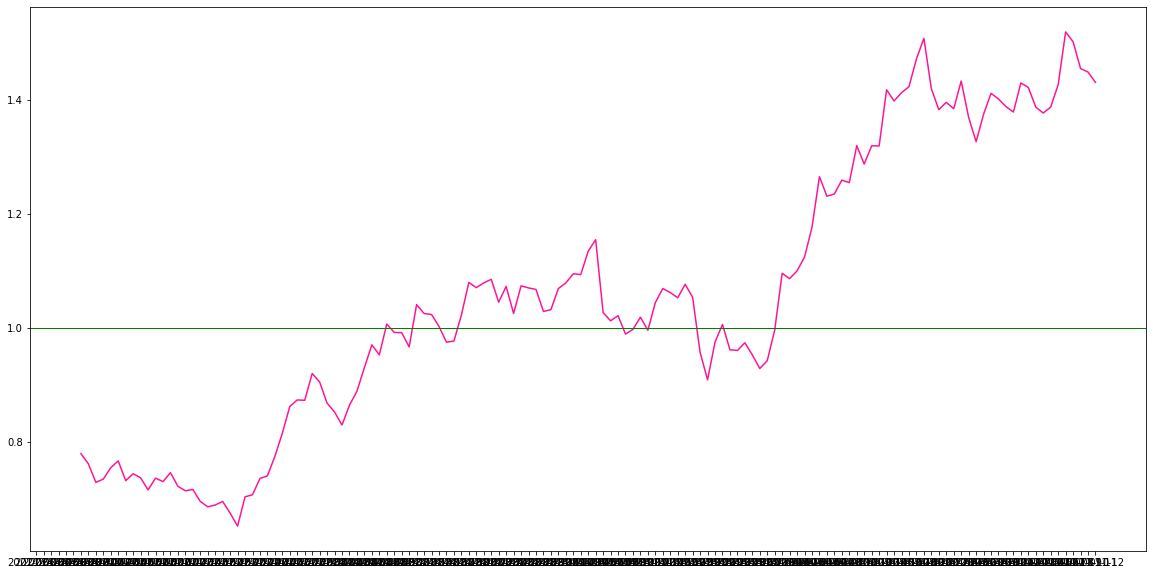

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['disparity180;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=1, color='g', linewidth=1)

plt.show()